In [36]:
import torch
import time
# from utils import *
# from model import *

torch.manual_seed(42)

In [37]:
import matplotlib.pyplot as plt

def plot_window(window):
    plt.figure(figsize=(10, 5))
    plt.plot(window, marker='o', linestyle='-')  # Using a line plot with markers
    plt.title('Timeline of 20 Values from a Sliding Window')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

In [38]:
import torch

# data_loader = torch.tensor([
#     [0.7500, 0.5000, 0.2500, 1.0000, 0.7500, 0.0000],
#     [0.5000, 0.2500, 0.0000, 0.7500, 0.0000, 0.2500],
#     [0.2500, 0.0000, 0.2500, 0.0000, 0.2500, 0.5000],
#     [0.5000, 0.7500, 1.0000, 0.2500, 0.5000, 0.7500],
#     [0.7500, 1.0000, 0.7500, 0.5000, 0.7500, 1.0000],
#     [1.0000, 0.7500, 0.5000, 0.7500, 1.0000, 0.7500]
# ])

def deviation_metrics(data):
    deviations = [torch.abs(x[-1] - x[-3]) for x in data]
    
    average_deviation = torch.median(torch.tensor(deviations))
    return average_deviation.item()

# deviation_metrics(data_loader)
# train_windows

Shape of train windows tensor: torch.Size([2430, 20])
tensor([[0.0000, 0.2500, 0.5000,  ..., 0.2500, 0.5000, 0.0000],
        [0.2500, 0.5000, 0.7500,  ..., 0.5000, 0.0000, 0.2500],
        [0.5000, 0.7500, 1.0000,  ..., 0.0000, 0.2500, 0.5000],
        ...,
        [0.5000, 0.7500, 1.0000,  ..., 0.2500, 0.5000, 0.7500],
        [0.7500, 1.0000, 0.7500,  ..., 0.5000, 0.7500, 1.0000],
        [1.0000, 0.7500, 0.5000,  ..., 0.7500, 1.0000, 0.7500]])
tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000, 0.7500, 0.5000, 0.2500, 0.0000,
        0.2500, 0.5000, 0.7500, 1.0000, 0.7500, 0.5000, 0.2500, 0.0000, 0.2500,
        0.5000, 0.0000])


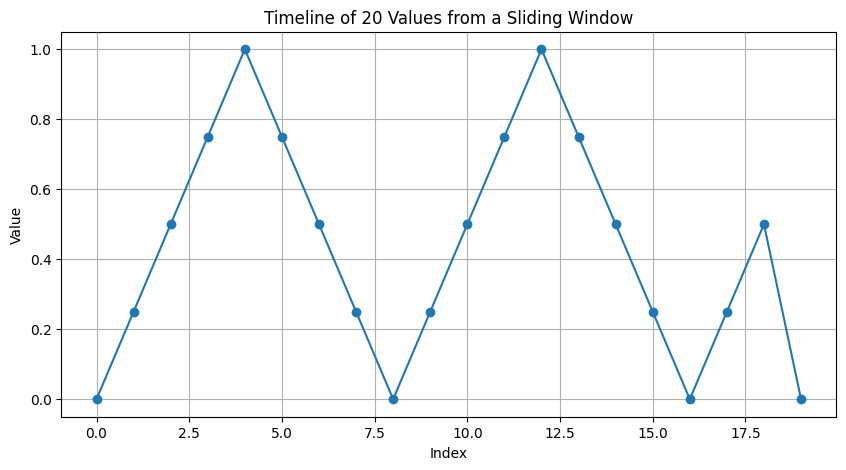

In [39]:
import torch
import pandas as pd

def load_energy_data(csv_file, start_idx, end_idx):
    """ Load energy data from a CSV file with specified indices."""
    energy_data = pd.read_csv(csv_file, parse_dates=True, index_col=0)
    return energy_data.iloc[start_idx:end_idx]

def create_windows(energy_data, window_size):
    """ Generate a tensor of all windows from the energy data."""
    num_windows = max(0, len(energy_data) - window_size + 1)
    windows = []
    for idx in range(num_windows):
        window = energy_data.iloc[idx:idx + window_size].values.flatten().astype(float)
        windows.append(window)
    if windows:  # Ensure there's at least one window to avoid error on empty list
        return torch.tensor(windows, dtype=torch.float32)
    else:
        return torch.tensor([])  # Return an empty tensor if no windows are possible

def create_datasets(csv_file, window_size, train_split=0.7, eval_train_split=0.95):
    total_rows = pd.read_csv(csv_file).shape[0]
    train_data = load_energy_data(csv_file, 0, int(total_rows * train_split))
    eval_train_data = load_energy_data(csv_file, int(total_rows * train_split), int(total_rows * eval_train_split))
    eval_test_data = load_energy_data(csv_file, int(total_rows * eval_train_split), total_rows)

    # Create windows for each dataset
    train_windows = create_windows(train_data, window_size)
    eval_train_windows = create_windows(eval_train_data, window_size)
    eval_test_windows = create_windows(eval_test_data, window_size)

    return train_windows, eval_train_windows, eval_test_windows

# Usage
csv_file = './data/TEST.csv'
window_size = 20  # Define the window size

train_windows, eval_train_windows, eval_test_windows = create_datasets(csv_file, window_size)
print("Shape of train windows tensor:", train_windows.shape if train_windows.nelement() else "No windows generated")

# Example access to a window in the train data
if train_windows.nelement():  # Check if tensor is not empty
    print(train_windows)
    print(train_windows[0])
    plot_window(train_windows[0])
# print(train_windows[0:20])

In [40]:
# data = torch.tensor([
#     [0.7500, 0.5000, 0.2500, 1.0000, 0.7500, 0.0000],
#     [0.5000, 0.2500, 0.0000, 0.7500, 0.0000, 0.2500],
#     [0.2500, 0.0000, 0.2500, 0.0000, 0.2500, 0.5000],
#     [0.5000, 0.7500, 1.0000, 0.2500, 0.5000, 0.7500],
#     [0.7500, 1.0000, 0.7500, 0.5000, 0.7500, 1.0000],
#     [1.0000, 0.7500, 0.5000, 0.7500, 1.0000, 0.7500]
# ])

def create_data_neg(data):    
    for el in data:
        pos = el[-3].item() + deviation + 0.2
        neg = el[-3].item() - deviation - 0.2
        if abs(el[-1] - pos) > abs(el[-1] - neg):
            el[-1] = neg
        else: 
            el[-1] = pos
    return data

In [41]:
import torch
import torch.nn as nn
from tqdm import tqdm

class FFNet(torch.nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.num_epochs = 11000
        self.layers = []
        self.device = torch.device("cpu")
        for d in range(len(dims) - 1):
            self.layers += [FFLayer(dims[d], dims[d + 1])]

    def train_3(self, data_loader):
        cached_data = []
        for epoch in tqdm(range(self.num_epochs)):
            epoch_loss = 0
            if epoch > 10998:
                self.predict(data_loader)
            h_batch_pos, h_batch_neg = data_loader, create_data_neg(data_loader)
            for layer_i, layer in enumerate(self.layers):
                h_batch_pos_epoch, h_batch_neg_epoch, loss = layer.train(h_batch_pos, h_batch_neg)
                epoch_loss += loss.item()
                h_batch_pos, h_batch_neg = h_batch_pos_epoch, h_batch_neg_epoch
            # print('   epoch {} loss: {}'.format(epoch + 1, epoch_loss))

    @torch.no_grad()
    def predict(self, x_batch):
        for i, x in enumerate(x_batch):    
            goodness = []
            for layer in self.layers:
                h_batch = layer(x)
                goodness += [h_batch.pow(2).mean(1)]
            print(sum(goodness) / len(goodness))

class FFLayer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.leakyrelu = torch.nn.LeakyReLU()
        self.rrelu = torch.nn.RReLU()
        self.gelu = torch.nn.GELU()
        self.opt = torch.optim.AdamW(self.parameters(), lr=0.1)
        self.threshold = 5.0

    def forward(self, x):
        if x.ndim == 1:
            x = x.unsqueeze(0)  # Add a batch dimension if it's missing
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        g_pos = self.forward(x_pos).pow(2).mean(1)
        g_neg = self.forward(x_neg).pow(2).mean(1)
        # The following loss pushes pos (neg) samples to values larger (smaller) than the self.threshold.
        loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()
        self.opt.zero_grad()
        # this backward just compute the derivative and hence is not considered backpropagation.
        loss.backward()
        self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach(), loss.detach()

In [42]:
# Example usage:
deviation = deviation_metrics(train_windows)
print(deviation)

net = FFNet([window_size, 20, 20])
#     
time_training_start = time.time()
net.train_3(train_windows)
time_training_end = time.time()
training_time = round(time_training_end - time_training_start, 2)
print(f"Training time: {training_time}s")

0.5


100%|█████████▉| 10998/11000 [04:55<00:00, 38.59it/s]

tensor([4.2016])
tensor([4.3751])
tensor([4.6045])
tensor([4.7399])
tensor([4.5344])
tensor([4.2709])
tensor([3.9458])
tensor([3.8648])
tensor([4.2839])
tensor([4.4608])
tensor([4.5297])
tensor([4.5339])
tensor([4.3154])
tensor([4.5051])
tensor([4.4295])
tensor([4.2929])
tensor([4.3219])
tensor([4.3117])
tensor([4.5876])
tensor([4.5795])
tensor([4.5888])
tensor([4.1935])
tensor([4.2902])
tensor([4.0308])
tensor([3.9606])
tensor([4.1637])
tensor([4.1294])
tensor([4.1930])
tensor([4.3913])
tensor([4.5227])
tensor([4.2624])
tensor([3.9822])
tensor([4.0304])
tensor([4.1041])
tensor([4.3073])
tensor([4.4497])
tensor([4.5578])
tensor([4.3247])
tensor([4.3204])
tensor([4.4626])
tensor([4.6648])
tensor([4.5466])
tensor([4.2991])
tensor([4.2667])
tensor([4.2074])
tensor([4.2816])
tensor([4.3749])
tensor([4.6056])
tensor([4.3063])
tensor([4.3281])
tensor([4.5784])
tensor([4.4462])
tensor([4.2276])
tensor([4.1304])
tensor([4.0934])
tensor([4.0126])
tensor([4.0471])
tensor([4.3231])
tensor([4.3883

100%|██████████| 11000/11000 [04:55<00:00, 37.24it/s]

tensor([4.5381])
tensor([4.7371])
tensor([4.6945])
tensor([4.4732])
tensor([4.4639])
tensor([4.5369])
tensor([4.3484])
tensor([4.2099])
tensor([4.2816])
tensor([4.3146])
tensor([4.3941])
tensor([4.3885])
tensor([4.6536])
tensor([4.7502])
tensor([4.3754])
tensor([4.2703])
tensor([4.2565])
tensor([4.1819])
tensor([4.2376])
tensor([4.4850])
tensor([4.5442])
tensor([4.4276])
tensor([4.3697])
tensor([4.4913])
tensor([4.5308])
tensor([4.3469])
tensor([4.3908])
tensor([4.5986])
tensor([4.4041])
tensor([4.2099])
tensor([4.2816])
tensor([4.2861])
tensor([4.1311])
tensor([4.4645])
tensor([4.7338])
tensor([4.6607])
tensor([4.4277])
Training time: 295.38s
